## The Pacific region named Niño 3.4 (5N-5S, 170W-120W) is used to define the Sea Surface Temperatures (SST) anomalies that defines a el Niño event. Moreover, the Oceanic Niño Index (ONI) is calculated based on the data of this region.  

## Taking this information into account, in this project we are going to focus in the study of that region and discard all other points. 


### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Check the data

In [2]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


### We use DBSCAN method from sklearn to cluster our observations. 
### Each cluster will correspond to one different buoy.

#### We will cluster the observations in base of their location. Thus, we define X with the longitude and latitude.

In [5]:
data['epoch_time'] = data['date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp("1970-01-01"))//pd.Timedelta('1s'))

In [27]:
X = data[['latitude', 'longitude' , 'year']].sample(100000)

#### We set the most important parameters.

In [228]:
eps = 3.0
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples = 120
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

In [229]:
#1.3 and 8

#### We initialize and fit the model

In [230]:
dbs = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=3.0, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=120, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [231]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
# silhouette_score(X, dbs.labels_, sample_size= 50000)

#### We add the labels from DBSCAN to a new column in the dataset.

In [232]:
X['buoy_label'] = dbs.labels_

In [233]:
len(X['buoy_label'].unique())

71

In [219]:
X['buoy_label'].value_counts().tail()

56    341
68    304
64    296
43    269
65    212
Name: buoy_label, dtype: int64

In [220]:
X['buoy_label'].value_counts().head()

9     8253
22    7001
12    3439
50    3150
30    2856
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

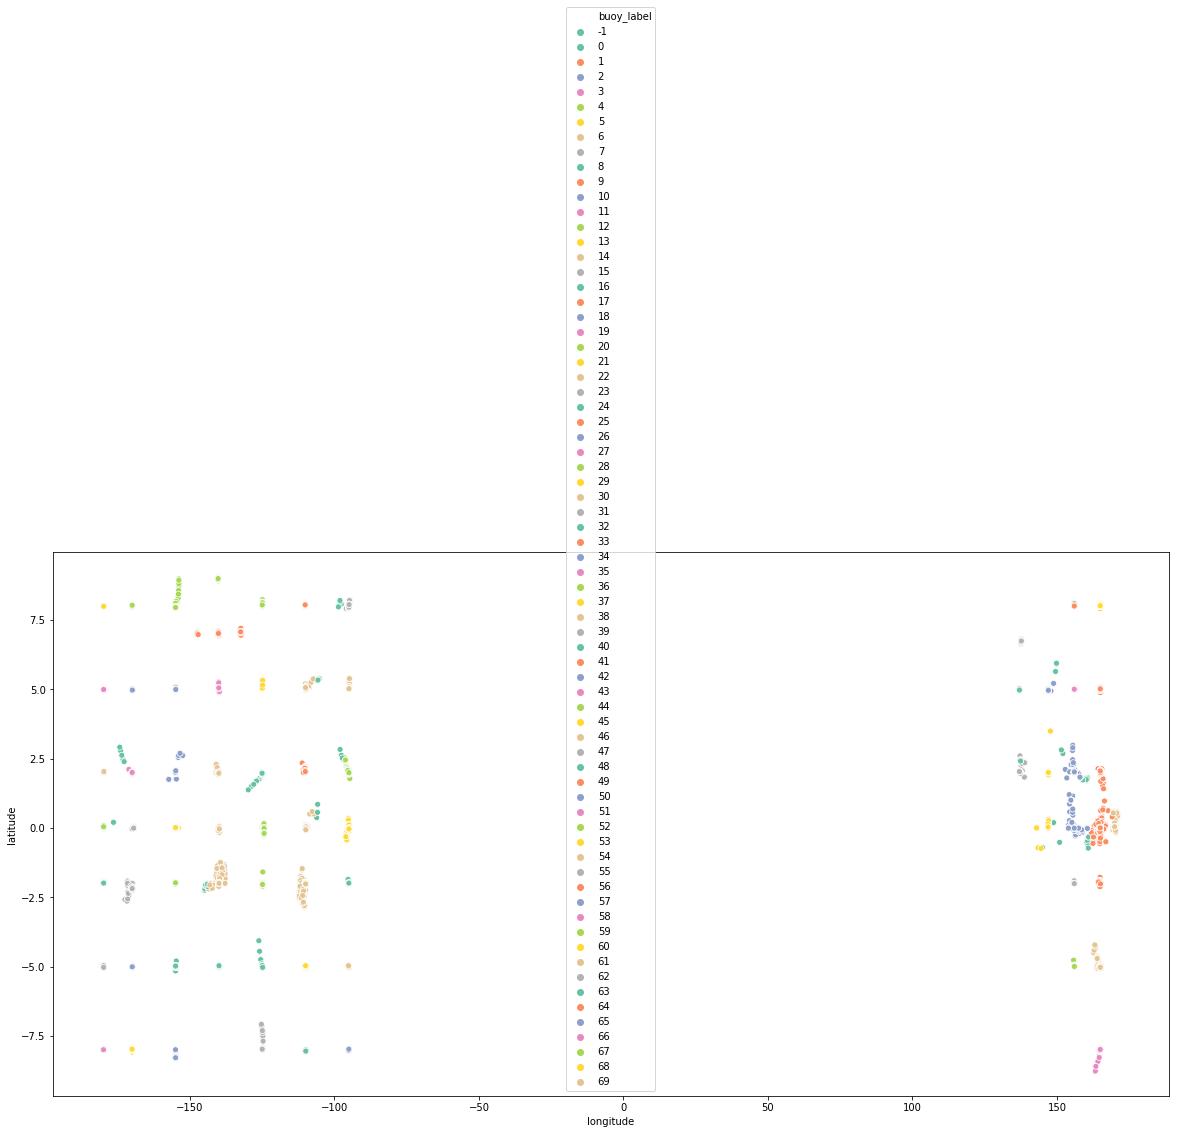

In [235]:
location = X[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

(2064, 3)


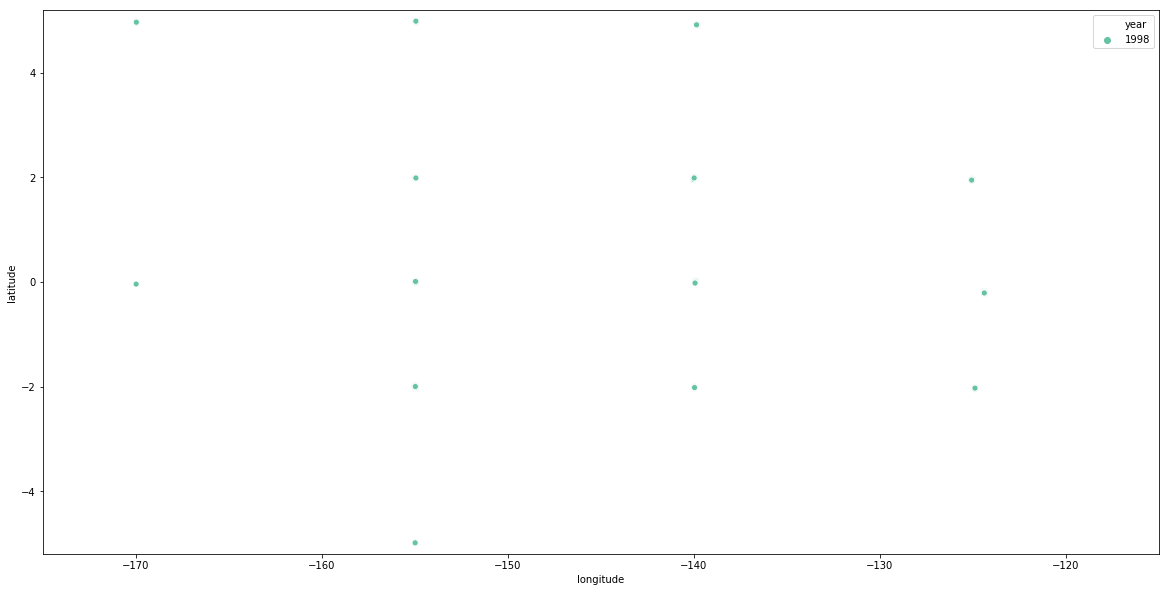

In [377]:
search = data[(data['latitude'] < 5) & (data['latitude'] > -5) & (data['longitude'] < -120) & (data['longitude'] > -170) & (data['year'] == 1998)][['latitude', 'longitude' , 'year']]
fig, ax = plt.subplots(figsize=(20, 10))
p = sns.scatterplot(x = search['longitude'], y = search['latitude'], hue=search['year'], palette = 'Set2', legend= 'full')
p.set(ylim=(-5.2, 5.2), xlim=((-175, -115)))
print(search.shape)

In [379]:
search.head()

,latitude,longitude,year
10115,-0.19,-124.40,1998
10116,-0.19,-124.40,1998
10117,-0.19,-124.40,1998
10118,-0.20,-124.41,1998
10119,-0.20,-124.41,1998


In [399]:
search_2 = data[(data['latitude'] < 5) & (data['latitude'] > -5) & (data['longitude'] < -120) & (data['longitude'] > -170) ][['date', 's.s.temp.']]
search_2 = data.groupby(by='date').mean()  
search_2['mer.winds'].iplot(kind='line', xTitle='Time',
           yTitle='Winds (m/s)', title='Air and set temperature between 1980 and  1998')

In [ ]:
# Moving average, 3 dies, 1 setmana...

#### Conclusion: I cannot fit any parameter combination in the DBSCAN so all groups are well defined. The reason for this is that the shapes of the groups are very different plus there are so many groups to classify. 
#### In order to perform a perfect group clustering I should divide the data into groups and run the analysis for each group. However, as it is not the main focus of my project, I'll leave it.

#### Other options are:
- Try another unsupervised method for clustering.
- Take into account more dimensions.

### Now, I will focus only in clustering the data from 4.0 to 6.0 N, because all observations in that latitude seems that are well grouped.

In [236]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [237]:
data.shape

(178080, 12)

In [253]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4)][['latitude', 'longitude' , 'year']]

In [255]:
X_5.shape

(26946, 3)

(1257, 3)


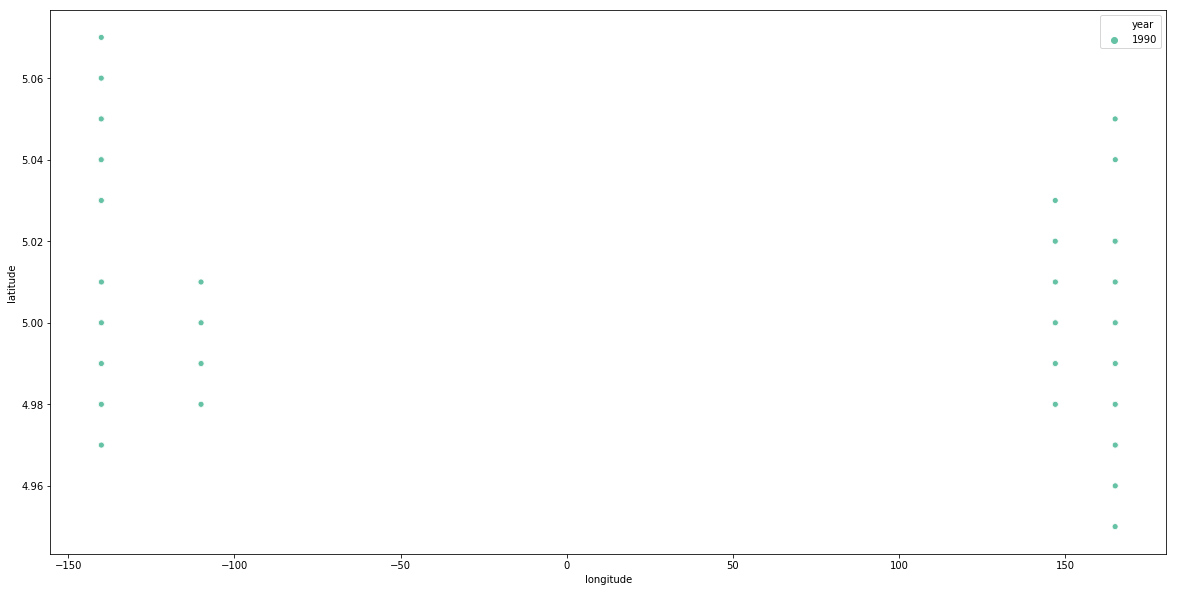

In [341]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4) & (data['year'] == 1990)][['latitude', 'longitude' , 'year']]
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x = X_5['longitude'], y = X_5 ['latitude'], hue=X_5['year'], palette = 'Set2', legend= 'full')
print(X_5.shape)

#### We use DBSCAN method from sklearn to cluster our observations. 
#### Each cluster will correspond to one different buoy.

#### We set the most important parameters.

In [256]:
eps_5 = 3.0
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples_5 = 120
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs_5 = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [261]:
dbs_5 = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs_5.fit(X_5)

DBSCAN(algorithm='auto', eps=3.0, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=120, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [231]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
# silhouette_score(X_5, dbs_5.labels_, sample_size= 50000)

#### We add the labels from DBSCAN to a new column in the dataset.

In [262]:
X_5['buoy_label'] = dbs_5.labels_

In [263]:
len(X_5['buoy_label'].unique())

11

In [264]:
X_5['buoy_label'].value_counts().tail()

8     2216
1     2161
9     1773
10    1506
2      691
Name: buoy_label, dtype: int64

In [265]:
X_5['buoy_label'].value_counts().head()

0    4147
7    3656
3    3308
4    2654
5    2531
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

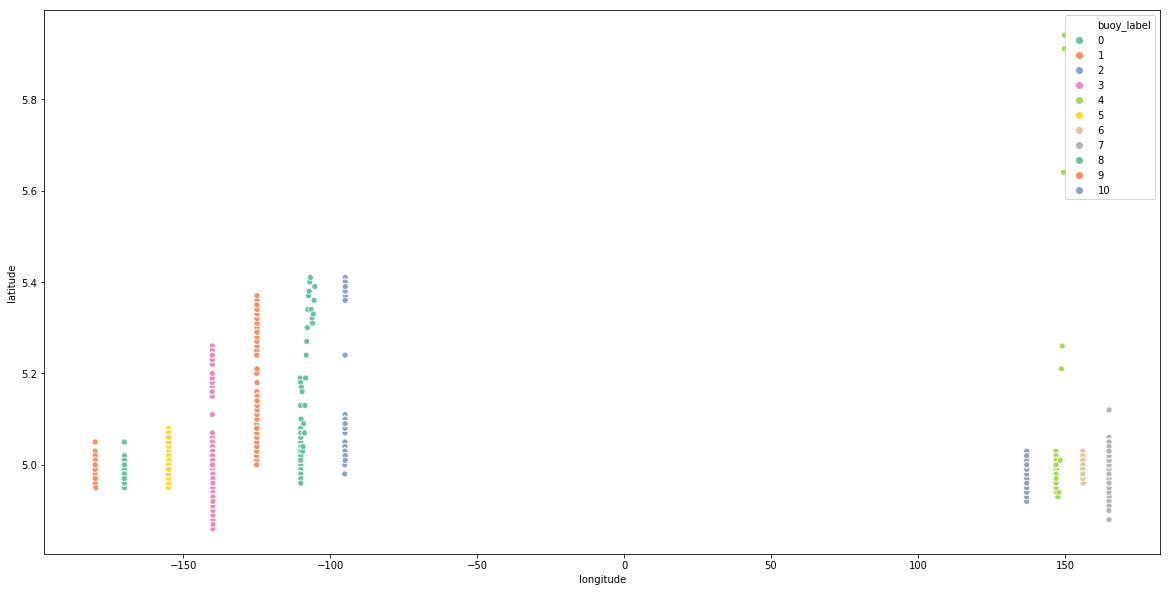

In [266]:
location = X_5[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

### We analyze the new clustered data

In [278]:
data_5N = data[(data['latitude'] < 6) & (data['latitude'] > 4)]
data_5N['buoy_label'] = X_5['buoy_label']

/home/atwenter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [279]:
data_5N.isna().sum()

obs              0
year             0
month            0
day              0
date             0
latitude         0
longitude        0
zon.winds     4712
mer.winds     4712
humidity      9466
air temp.     1740
s.s.temp.     1413
buoy_label       0
dtype: int64

In [280]:
data_5N.shape

(26946, 13)

In [281]:
data_5N[data_5N['date'] > '1984-01-01'].head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
93184,93185,1985,11,9,1985-11-09,5.00,-110.00,NaN,NaN,NaN,23.93,26.48,0
93185,93186,1985,11,10,1985-11-10,5.00,-110.00,NaN,NaN,NaN,25.26,26.48,0
93186,93187,1985,11,11,1985-11-11,5.06,-110.02,NaN,NaN,NaN,25.01,26.45,0
93187,93188,1985,11,12,1985-11-12,5.06,-110.02,NaN,NaN,NaN,24.99,26.52,0
93188,93189,1985,11,13,1985-11-13,5.05,-110.01,NaN,NaN,NaN,25.11,26.55,0


In [292]:
data_5N_x = data_5N.groupby(by=['date']).mean()

In [306]:
data_5N_x.isna().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds      227
mer.winds      227
humidity      1738
air temp.       24
s.s.temp.      184
buoy_label       0
dtype: int64

In [307]:
data_5N_x[data_5N_x["s.s.temp."].isnull()]

,obs,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
date,,,,,,,,,,,,
1985-12-23,93229.000000,1985.0,12.0,23.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,0.000000
1985-12-31,93237.000000,1985.0,12.0,31.0,5.050000,-110.03,NaN,NaN,NaN,NaN,NaN,0.000000
1986-01-12,93249.000000,1986.0,1.0,12.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,0.000000
1986-01-31,93268.000000,1986.0,1.0,31.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,0.000000
1986-03-14,93310.000000,1986.0,3.0,14.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,0.000000
1986-03-15,93311.000000,1986.0,3.0,15.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,0.000000
1986-06-01,93389.000000,1986.0,6.0,1.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,0.000000
1986-06-02,93390.000000,1986.0,6.0,2.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,0.000000
1986-06-03,93391.000000,1986.0,6.0,3.0,5.000000,-110.00,NaN,NaN,NaN,NaN,NaN,0.000000


In [347]:

data_5N_x[['mer.winds']].iplot(kind='line', xTitle='Time',
           yTitle='Air/Sea Temperature (ºC)', title='Air and set temperature between 1980 and  1998')

#### We copy the well assigned observations to a new .csv.

In [272]:
data_5.to_csv('../Data/obs_5N_labelled.csv')

# Ask TA, why this doesn't work.

In [ ]:
# Random CV -CHECKING BEST PARAMETER COMBINATION FOR DBSCAN


DBS_best = DBSCAN(n_jobs)

# Parameters to try
parameter_grid = {'eps': np.linspace(0.1,2,20),
                 'min_samples' : [i for i in range(1, 20)]}

#Scoring
silhouette = make_scorer(silhouette_score(X, DBS_best.labels_ , sample_size= 500))


# Create grid search object on decision tree using stratified cross validation
n_iter_search = 20
random_search = RandomizedSearchCV(DBS_best,
                           param_distributions=parameter_grid,
                           n_iter=n_iter_search, cv=5, n_jobs=-1,
                            scoring=silhouette)

# Fit model with grid_search
random_search.fit(X)
print('Best score: {}'.format(random_search.best_score_))
print('Best parameters: {}'.format(random_search.best_params_))